### Load data and plotting functions

In [ ]:
import pandas as pd
import duckdb


def load_results(res_list):
    df_list = []
    for f in res_list:
        df = pd.read_csv(f)
        df_list.append(df)
    df = pd.concat(df_list)

    sql = """
        SELECT 
            ((max(CAST(qid AS INTEGER))+1)/3)::INTEGER as qid,
            spatial_resolution, 
            temporal_resolution,
            time_span, 
            area_persent, 
            category, 
            avg(execution_time) as avg_execution_time
        FROM df
        GROUP BY spatial_resolution, temporal_resolution, time_span, area_persent, category
        ORDER BY max(qid)
        """
    df_avg = duckdb.query(sql).to_df()

    return df_avg

def load_results_row_swap(res_list):
    df_avg = load_results(res_list=res_list)
    # adding 3yr point for temporal resolution
    last_row = df_avg.iloc[-1:]
    df_final = df_avg.iloc[:-1]
    df_final = pd.concat([df_avg.iloc[:5], last_row, df_avg.iloc[5:-1]], ignore_index=True)
    
    return df_final

def load_find_time_results(res_list):
    df_list = []
    for f in res_list:
        df = pd.read_csv(f)
        df_list.append(df)
    df = pd.concat(df_list)

    sql = """
        SELECT 
            ((max(qid)+1)/3)::integer as qid, 
            category, 
            time_span,
            filter_value,
            avg(execution_time) as avg_execution_time
        FROM df
        GROUP BY category, time_span, filter_value
        ORDER BY max(qid)
        """
    df_avg = duckdb.query(sql).to_df()
    return df_avg


Import config

In [ ]:
import json
json_file = "/home/uribe055/experiment-kit/experiment/results/config.json"
with open(json_file, "r") as f:
    cj = json.load(f)

Read in data

In [ ]:
import glob

systems_list = ["proposed", "vanilla", "cloud", "tiledb"]
queries_list = ["raster", "heatmap", "findtime"]

ls = []
# read in all 
for s in systems_list:
    for q in queries_list:
        cur_glob = glob.glob(cj[s][q])
        cur_df = load_results(cur_glob)

Function to plot plots

In [ ]:
import matplotlib.pyplot as plt

def custom_plot(df1, df2, df3, df4, 
                df3bool, df4bool, 
                nrows, ncols, 
                rowsize, colsize, 
                labsx, labsy, linearbool, ticksize, ticklist, ticklabels,
                subtitles, subtitlesfontsize, subplotyspacing,
                figtitle, figtitlefontsize, 
                categories, barlegendbool, 
                markernames, markersize, markerfills, 
                systemnames, linestyles, linewidth, 
                padding, anchor):
    
    fig, axs = plt.subplots(nrows, ncols, figsize=(colsize, rowsize), sharey=True)
    
    if nrows + ncols > 2:
        axs = axs.flatten()

        for i, (category, x_lab) in enumerate(zip(categories, labsx)):
            df1_cat = df1[df1["category"] == category]  # proposed
            df2_cat = df2[df2["category"] == category]  # vanilla

            df_list = [df1_cat, df2_cat]

            if df3bool: #cloud
                df3_cat = df3[df3["category"] == category]
                df_list.append(df3_cat)
            if df4bool: # tiledb
                df4_cat = df4[df4["category"] == category]
                df_list.append(df4_cat)

            x_col = cj["general"]["x_col"][category]

            if not linearbool:
                axs[i].set_yscale("log", base=10)

            customizations = zip(df_list, systemnames, markernames, markerfills, linestyles)
            
            for df, s_name, m_name, m_fill, l_style, in customizations:

                # plot each system's line
                axs[i].plot(df[x_col], df["avg_execution_time"], label=s_name, 
                                marker=m_name, ms=markersize, fillstyle=m_fill, linestyle=l_style)
            
            # set subplot axis params
            axs[i].tick_params(axis="both", labelsize=ticksize)

            if ticklist is not None:
                axs[i].set_xticks(ticks=ticklist[i], labels=ticklabels[i])
            axs[i].set_title(subtitles[i], fontsize=subtitlesfontsize, fontweight='bold', y=subplotyspacing, va=cj["genera"]["below"])
            axs[i].set_xlabel(x_lab, )
                
            

In [ ]:
import matplotlib.pyplot as plt



def plot_2x2(tdb, cld, linear, df_proposed, df_vanilla, df_cloud, df_tiledb,
             rows, cols, row_size, col_size,
             categories, x_labels, y_label, label_titles, title, title_size, subplot_titles, 
             marker_names, marker_size, mfill, 
             lstyle, tick_size, tick_list, tick_labels,
             outfile, padding=3, subplot_y=-0.2, bar_legend=True, anchor=(0.5, 1.01)):

    fig, axs = plt.subplots(rows, cols, figsize=(col_size, row_size), sharey=True)
    axs = axs.flatten()
    
    for i, (category, xlabel) in enumerate(zip(categories, x_labels)):
        df_proposed_cat = df_proposed[df_proposed["category"] == category]
        df_vanilla_cat = df_vanilla[df_vanilla["category"] == category]
        cat_dfs_list = [df_proposed_cat, df_vanilla_cat]
        if cld:
            df_cloud_cat = df_cloud[df_cloud["category"] == category]
            cat_dfs_list.append(df_cloud_cat)
        if tdb:
            df_tiledb_cat = df_tiledb[df_tiledb["category"] == category]
            cat_dfs_list.append(df_tiledb_cat)
        
        if category == "changing_area":
            x_col = "area_persent"
        elif category == "changing_time":
            x_col = "time_span"
        elif category == "changing_spatial_res":
            x_col = "spatial_resolution"
        elif category == "changing_value":
            x_col = "filter_value"
        else:  # "changing_temporal_res"
            x_col = "temporal_resolution"

        if not linear:
            axs[i].set_yscale("log", base=10)  # Set y-axis to logarithmic scale
        
        for df, label, marker, ls, mf in zip(cat_dfs_list, label_titles, marker_names, lstyle, mfill):
            
            axs[i].plot(df[x_col], df["avg_execution_time"], label=label, 
                            linestyle=ls, linewidth=3, marker=marker, ms=marker_size, fillstyle=mf)
            
        axs[i].tick_params(axis='both', labelsize=tick_size)
        if tick_list is not None:
            axs[i].set_xticks(ticks=tick_list[i], labels=tick_labels[i])
        axs[i].set_title(subplot_titles[i], fontsize=title_fs, fontweight='bold', y=subplot_y, va=below)
        axs[i].set_xlabel(xlabel, fontsize=fs)
        # axs[i].legend(fontsize=fs)    # legend in each plot

        if i==1:
            lines, labels = axs[i].get_legend_handles_labels()
            if bar_legend:
                axs[i].legend().remove()

        if i%2==0:
            axs[i].set_ylabel(y_label, fontsize=fs)

    if bar_legend:
        fig.legend(lines, labels, loc='upper center', bbox_to_anchor=anchor, fontsize=fs, ncol=len(cat_dfs_list))
    else:
        fig.legend(lines, labels, loc='upper left', bbox_to_anchor=(0.15, 0.95), fontsize=fs)  #(0.2, 0.97) for stacked plots
    
    # fig.suptitle(title, fontsize=title_size)    # figure title
    fig.tight_layout(pad=padding)
    
    # plt.savefig(outfile)
    
    plt.show()

def plot_heatmap_results(df_p, df_v, df_t, xlab, ylab, row_size, col_size, tick_list, tick_labels, title, mfill, outfile, subplot_y=-0.2, linear=True):
    
    fig, axs = plt.subplots(1, 1, figsize=(col_size, row_size), sharey=True)
    df_changing_time = df_p[df_p["category"] == "changing_time"]
    df_vanilla_changing_time = df_v[df_v["category"] == "changing_time"]
    df_tiledb_changing_time = df_t[df_t["category"]=="changing_time"]

    if not linear:
            axs.set_yscale("log", base=10)  # Set y-axis to logarithmic scale
    
    axs.plot(df_changing_time["time_span"], df_changing_time["avg_execution_time"], label=pname, 
                 linestyle=lstyle_1d[0], marker=marker_1d[0], ms=marker_size, fillstyle=mfill[0])
    
    axs.plot(df_vanilla_changing_time["time_span"], df_vanilla_changing_time["avg_execution_time"], label=vname, 
                 linestyle=lstyle_1d[1], marker=marker_1d[1], ms=marker_size, fillstyle=mfill[1])

    axs.plot(df_tiledb_changing_time["time_span"], df_tiledb_changing_time["avg_execution_time"], label=tname, 
                 linestyle=lstyle_1d[3], marker=marker_1d[3], ms=marker_size, color='tab:red', fillstyle=mfill[3])
    
    axs.set_title(title, fontsize=title_fs, fontweight='bold', y=subplot_y, va=below)
    axs.set_xlabel(xlab, fontsize=fs)
    axs.set_ylabel(ylab, fontsize=fs)
    axs.set_xticks(ticks=tick_list, labels=tick_labels)
    axs.legend(fontsize=fs)
    
    # fig.suptitle("Heatmap Query Performance")    # add fig title
    fig.tight_layout()
    # plt.savefig(outfile)
    plt.show()


# Find time

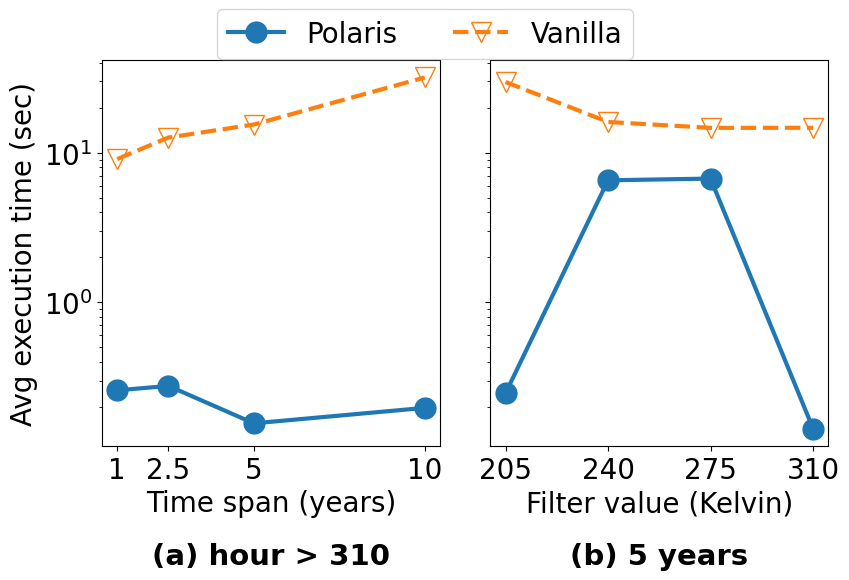

In [146]:
plot_2x2(tdb=False, cld=False, linear=False, df_proposed=df_p_ft_final, df_vanilla=df_v_ft_final, df_cloud=None, df_tiledb=df_tdb_ft,
         rows=1, cols=2, row_size=6, col_size=9, bar_legend=True,
         categories=categories_ft, x_labels=xlabels_ft, y_label=ylabel_ft, label_titles=label_025h[:2], 
         title="Find Time Query Performance", title_size=title_fs, subplot_titles=subplot_titles_ft_short,
         marker_names=marker_025h[:2], marker_size=marker_size, mfill=marker_fill_025h[:2],
         lstyle=lstyle_025h[:2], tick_size=tick_size, tick_list=tick_list_ft, tick_labels=tick_labels_ft,
         outfile="/home/uribe055/experiment-kit/experiment/results/figures/find_time.eps", 
         padding=2.5, subplot_y=-0.27, anchor=(0.5, 1.05))

# Heatmap

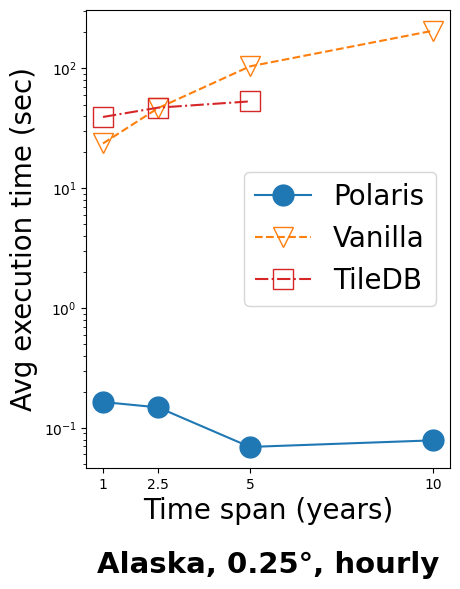

In [148]:
plot_heatmap_results(df_p=df_p_h, df_v=df_v_h, df_t=df_tdb_h, linear=False,
                     xlab=xlabel_hm, ylab=ylabel_hm, row_size=6, col_size=4.7,
                     tick_list=tick_list_hm, tick_labels=tick_labels_hm,
                     title=title_hm, mfill=marker_fill_1d, 
                     outfile="/home/uribe055/experiment-kit/experiment/results/figures/heatmap.eps")

# 0.25 hourly log scale
**Using reverse run for vanilla temporal resolution**

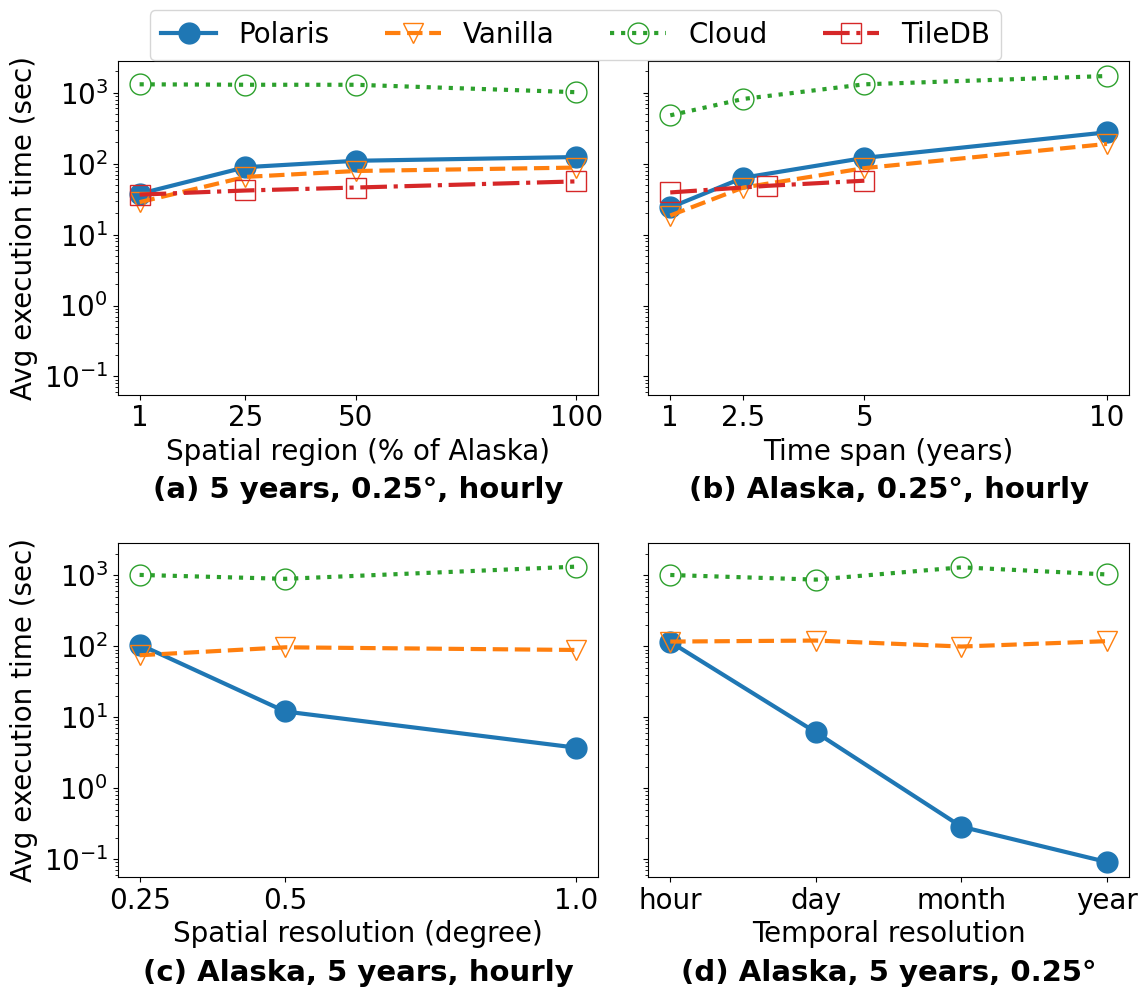

In [125]:
plot_2x2(tdb=True, linear=False, cld=True, rows=2, cols=2, row_size=10, col_size=12,
         df_proposed=df_proposed, df_vanilla=df_vr, df_cloud=df_cloud, df_tiledb=df_tiledb,
         categories=categories, x_labels=x_labels,y_label=ylabel_all, label_titles=label_1d, 
         title=figtitle_1d, title_size=title_fs, subplot_titles=titles_025h_short,
         marker_names=marker_1d, marker_size=marker_size, mfill=marker_fill_1d,
         lstyle=lstyle_1d, tick_size=tick_size, tick_list=tick_list_025h, tick_labels=tick_labels_025h,
         outfile="/home/uribe055/experiment-kit/experiment/results/figures/log_get_raster_025h_tdb.eps", 
         padding=2.5, subplot_y=-0.27, anchor=(0.5, 1.03))

---
### Linear version with tiledb

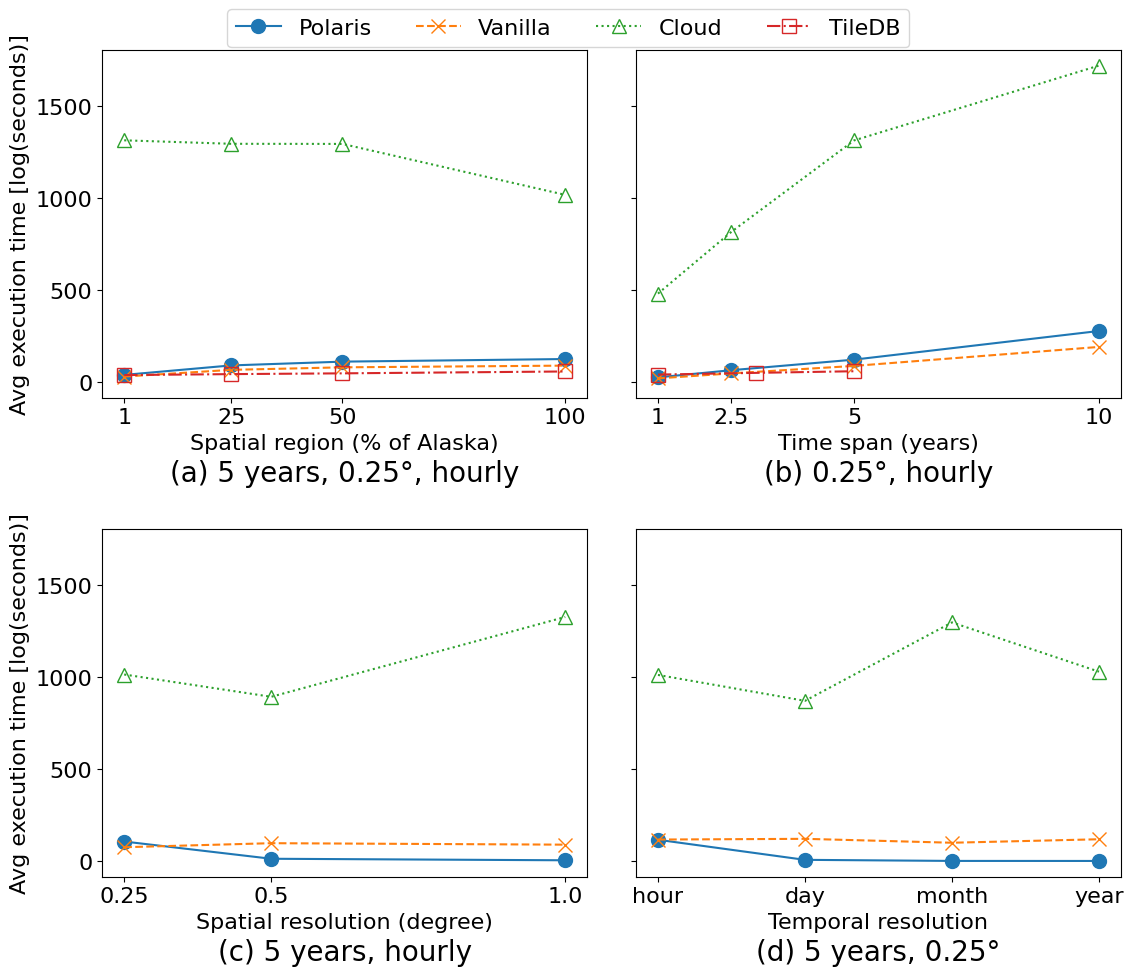

In [21]:
plot_2x2(tdb=True, linear=True, cld=True, rows=2, cols=2, df_proposed=df_proposed, df_vanilla=df_vr, df_cloud=df_cloud, df_tiledb=df_tiledb,
         categories=categories, x_labels=x_labels,y_label=ylabel_all, label_titles=label_1d, 
         title=figtitle_1d, title_size=title_fs, subplot_titles=titles_025h_short,
         marker_names=marker_1d, marker_size=marker_size, mfill=marker_fill_1d,
         lstyle=lstyle_1d, tick_size=tick_size, tick_list=tick_list_025h, tick_labels=tick_labels_025h,
         outfile="/home/uribe055/experiment-kit/experiment/results/figures/linear_get_raster_025h_tdb.pdf")

---
### Log version without tiledb

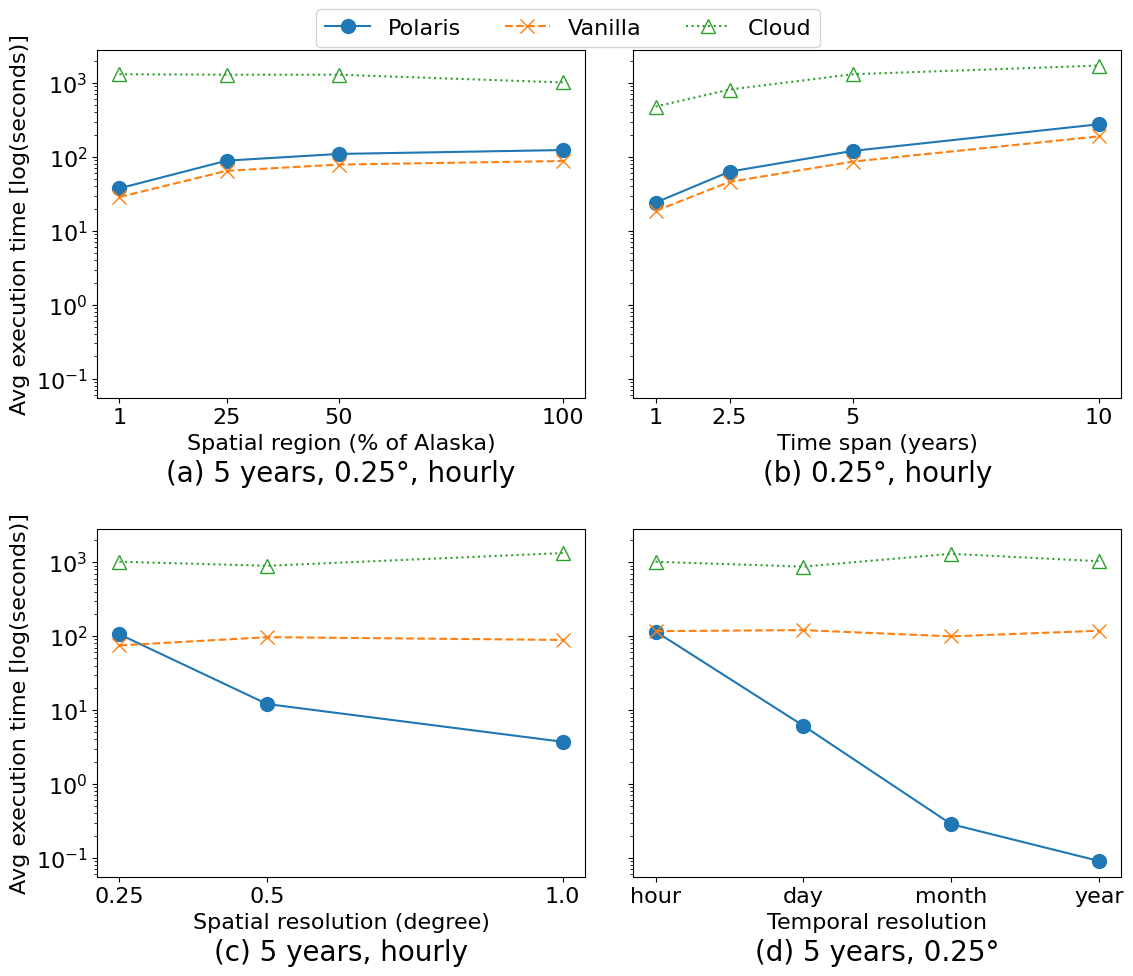

In [17]:
plot_2x2(tdb=False, cld = True, linear=False, df_proposed=df_proposed, df_vanilla=df_vr, df_cloud=df_cloud, df_tiledb=None,
         categories=categories, rows=2, cols=2, x_labels=x_labels, y_label = ylabel_all, label_titles=label_025h, 
         title=figtitle_025h, title_size=title_fs, subplot_titles=titles_025h_short,
         marker_names=marker_025h, marker_size=marker_size, mfill=marker_fill_025h,
         lstyle=lstyle_025h, tick_size=tick_size, tick_list=tick_list_025h, tick_labels=tick_labels_025h,
         outfile="/home/uribe055/experiment-kit/experiment/results/figures/log_get_raster_025h.pdf")

---
### Linear version without tiledb

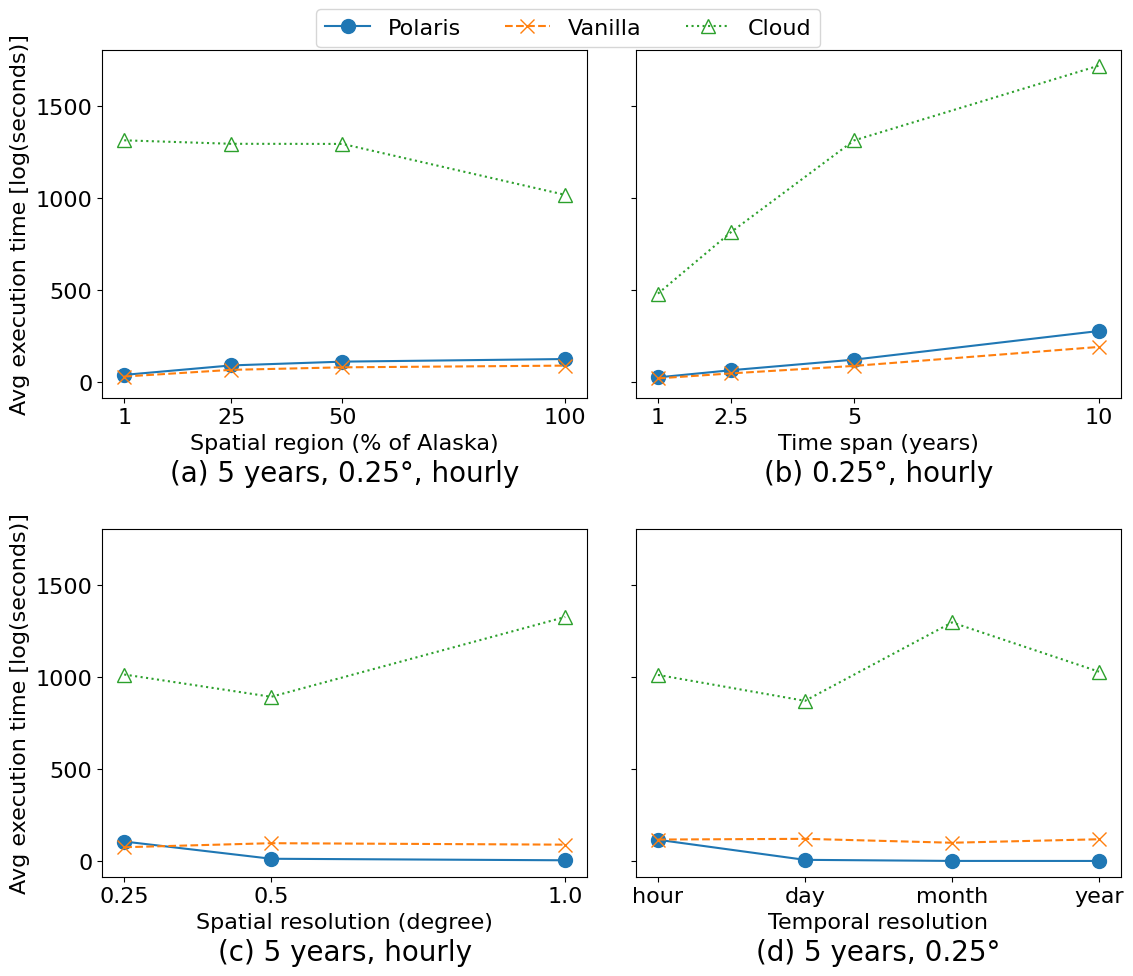

In [19]:
plot_2x2(tdb=False, linear=True, cld=True, rows=2, cols=2, df_proposed=df_proposed, df_vanilla=df_vr, df_cloud=df_cloud, df_tiledb=None,
         categories=categories, x_labels=x_labels, y_label=ylabel_all, label_titles=label_025h, 
         title=figtitle_025h, title_size=title_fs, subplot_titles=titles_025h_short,
         marker_names=marker_025h, marker_size=marker_size, mfill=marker_fill_025h,
         lstyle=lstyle_025h, tick_size=tick_size, tick_list=tick_list_025h, tick_labels=tick_labels_025h,
         outfile="/home/uribe055/experiment-kit/experiment/results/figures/linear_get_raster_025h.pdf")

# 1.0 degree daily log scale

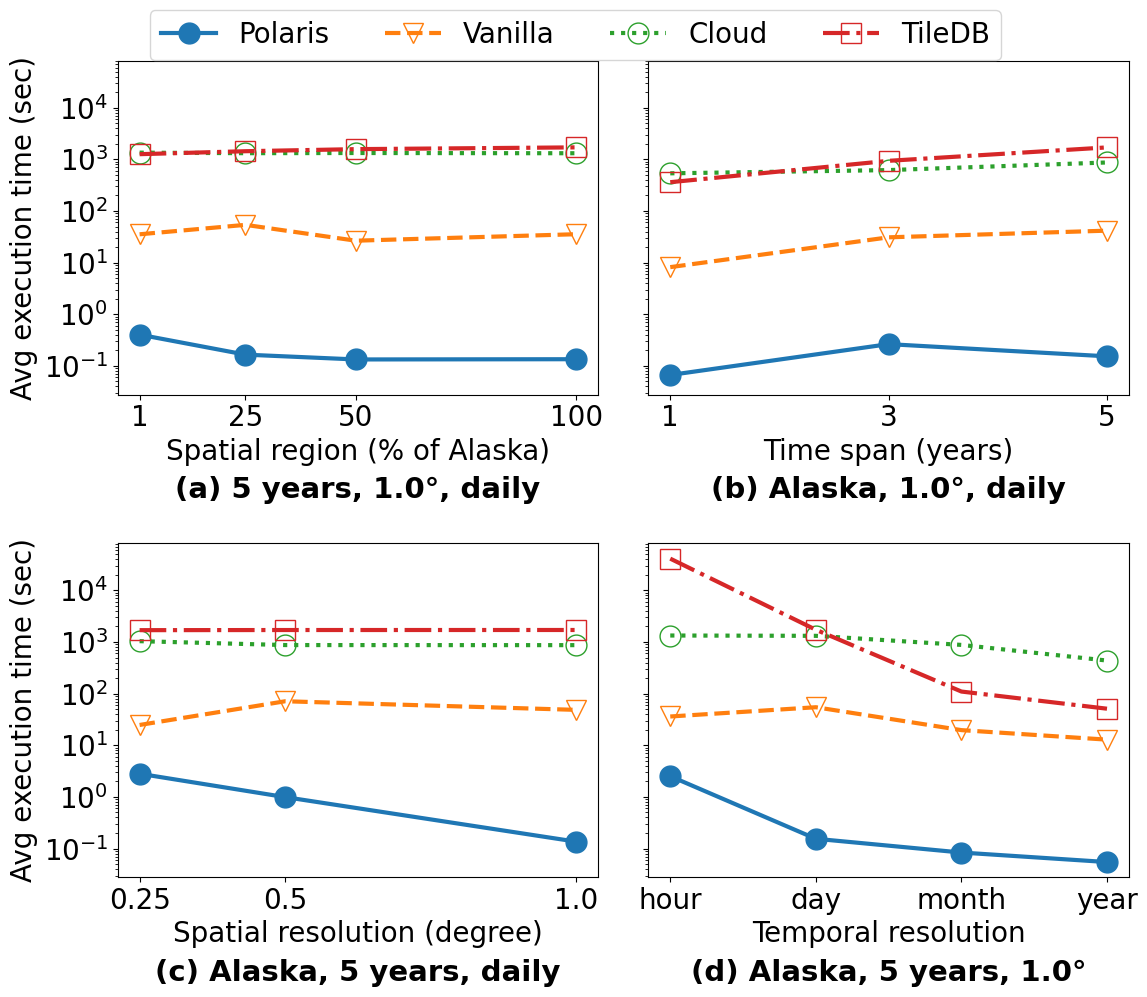

In [138]:
plot_2x2(tdb=True, cld=True, rows=2, cols=2, row_size=10, col_size=12, y_label=ylabel_all,
         linear=False, df_proposed=df_proposed_1d, df_vanilla=df_vanilla_1d, df_cloud=df_cloud_1d, df_tiledb=df_tiledb_1d,
         categories=categories, x_labels=x_labels, label_titles=label_1d, 
         title=figtitle_1d, title_size=title_fs, subplot_titles=titles_1d_short,
         marker_names=marker_1d, marker_size=marker_size, mfill=marker_fill_1d,
         lstyle=lstyle_1d, tick_size=tick_size, tick_list=tick_list_1d, tick_labels=tick_labels_1d,
         outfile="/home/uribe055/experiment-kit/experiment/results/figures/log_get_raster_1d.pdf", padding=2.5, subplot_y=-0.27, anchor=(0.5, 1.03))

---
### Linear version

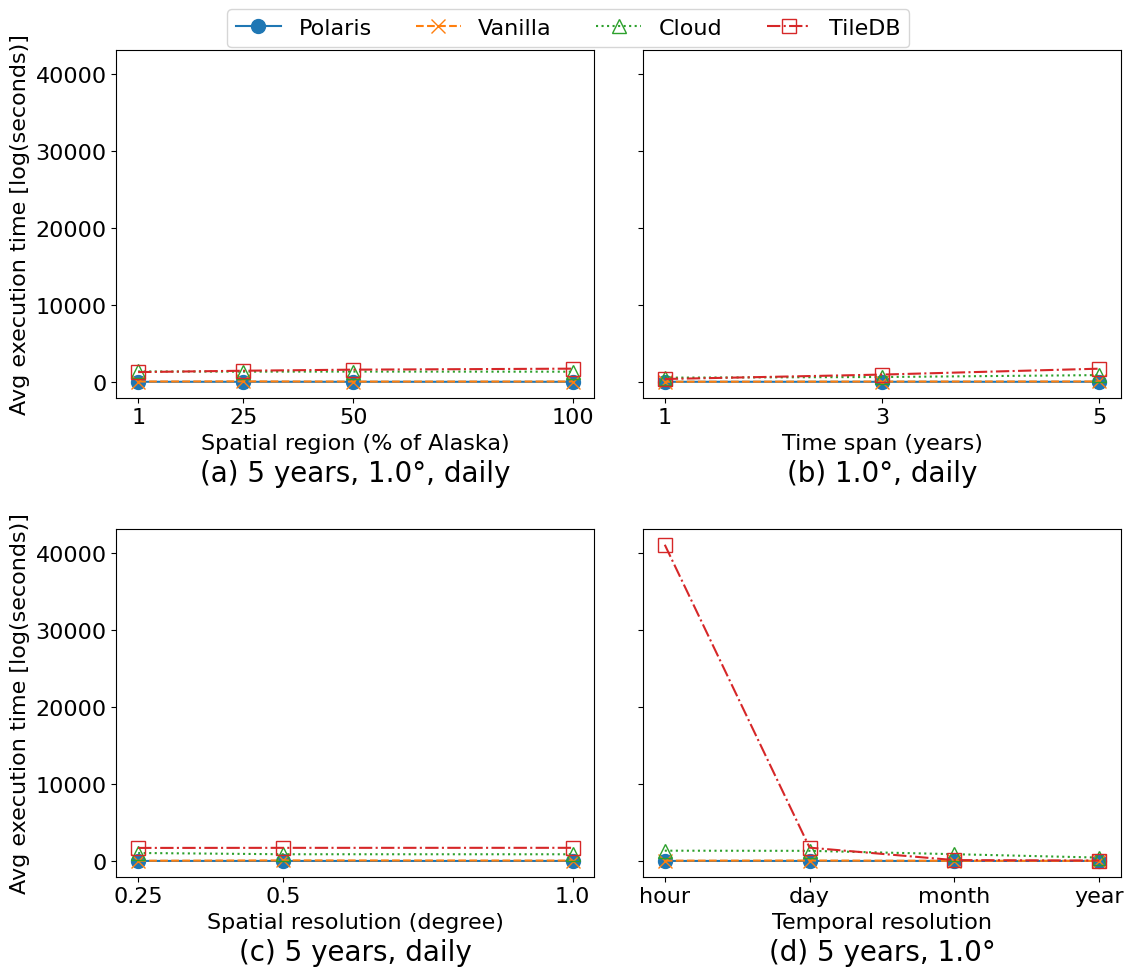

In [167]:
plot_2x2(tdb=True, linear=True, df_proposed=df_proposed_1d, df_vanilla=df_vanilla_1d, df_cloud=df_cloud_1d, df_tiledb=df_tiledb_1d,
         categories=categories, x_labels=x_labels, label_titles=label_1d, 
         title=figtitle_1d, title_size=title_fs, subplot_titles=titles_1d_short,
         marker_names=marker_1d, marker_size=marker_size, mfill=marker_fill_1d,
         lstyle=lstyle_1d, tick_size=tick_size, tick_list=tick_list_1d, tick_labels=tick_labels_1d,
         outfile="/home/uribe055/experiment-kit/experiment/results/figures/linear_get_raster_1d.pdf")